In [279]:
# Uncomment and run this cell if you're on Colab or Kaggle
!git clone https://github.com/nlp-with-transformers/notebooks.git
%cd notebooks
from install import *
install_requirements()

Cloning into 'notebooks'...
remote: Enumerating objects: 283, done.
remote: Counting objects: 100% (283/283), done.
remote: Compressing objects: 100% (207/207), done.
remote: Total 283 (delta 161), reused 148 (delta 70), pack-reused 0
Receiving objects: 100% (283/283), 13.55 MiB | 16.66 MiB/s, done.
Resolving deltas: 100% (161/161), done.
/content/notebooks/notebooks
⏳ Installing base requirements ...
✅ Base requirements installed!
⏳ Installing Git LFS ...
✅ Git LFS installed!


In [280]:
# hide
from utils import *
setup_chapter()

Using transformers v4.11.3
Using datasets v1.16.1


## The Dataset

To build our emotion detector we'll use a great dataset from an article that explored how emotions are represented in English Twitter messages.footnote:[E. Saravia et al., "CARER: Contextualized Affect Representations for Emotion Recognition," _Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing_ (Oct–Nov 2018): 3687–3697, http://dx.doi.org/10.18653/v1/D18-1404.] Unlike most sentiment analysis datasets that involve just "positive" and "negative" polarities, this dataset contains six basic emotions: anger, disgust, fear, joy, sadness, and surprise. Given a tweet, our task will be to train a model that can classify it into one of these emotions.

### A First Look at Hugging Face Datasets

We will use image:images/logo.png[hf,13,13] Datasets to download the data from the [Hugging Face Hub](https://huggingface.co/datasets). We can use the `list_datasets()` function to see what datasets are available on the Hub:

In [7]:
from bs4 import BeautifulSoup

In [3]:
from datasets import list_datasets

all_datasets = list_datasets()
print(f"There are {len(all_datasets)} datasets currently available on the Hub")
print(f"The first 10 are: {all_datasets[:10]}")

There are 3349 datasets currently available on the Hub
The first 10 are: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa',
'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue',
'ajgt_twitter_ar', 'allegro_reviews']


In [281]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [282]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Data/new_data-2021-02-21T10_21_35.050Z.csv",header=None, sep="," , names=["text", "label"])

In [283]:
df.head()

,text,label
0,in any instance where a delegate did not atten...,Inventory Management
1,any committee established as a result of presc...,Inventory Management
2,to ensure proper operation of the overall secu...,"Physical Security,Security Monitoring"
3,if the first few tests do not indicate problem...,Physical Security
4,for many organizations there are added benefit...,Physical Security


In [284]:
# clean the text in Body column
df['text'] = df['text'].str.lower()

In [285]:
df['label'] = df['label'].str.lower()

In [286]:
df['label'] = df['label'].astype('str').apply(lambda x: x.split(',')) 

In [287]:
df.head()

,text,label
0,in any instance where a delegate did not atten...,[inventory management]
1,any committee established as a result of presc...,[inventory management]
2,to ensure proper operation of the overall secu...,"[physical security, security monitoring]"
3,if the first few tests do not indicate problem...,[physical security]
4,for many organizations there are added benefit...,[physical security]


In [288]:
df["label"].values[:5]

array([list(['inventory management']), list(['inventory management']),
       list(['physical security', 'security monitoring']),
       list(['physical security']), list(['physical security'])],
      dtype=object)

In [289]:
# Encode the tags(labels) in a binary format in order to be used for training

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
 
yt = mlb.fit_transform(df['label'])
yt.shape

(18265, 18)

In [290]:
# Getting a sense of how the tags data looks like
print(yt[0])
print(mlb.inverse_transform(yt[0].reshape(1,-1)))
print(mlb.classes_)

[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
[('inventory management',)]
['application governance' 'business continuity management'
 'cloud services' 'communication technology' 'compliance management'
 'cryptography' 'data loss prevention' 'data protection and privacy'
 'identity and access management' 'information classification'
 'inventory management' 'nan' 'outsourcing' 'physical security'
 'procurement' 'risk management' 'security management'
 'security monitoring']


In [291]:
a = pd.DataFrame(data=yt, columns=mlb.classes_,dtype=float)

In [292]:
df['label'] = a.values.tolist()

In [293]:
df.head()

,text,label
0,in any instance where a delegate did not atten...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,any committee established as a result of presc...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,to ensure proper operation of the overall secu...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,if the first few tests do not indicate problem...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,for many organizations there are added benefit...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [190]:
#df['label'] = df['label'].astype(float)

In [294]:
import numpy as np

In [295]:
train, validate, test = \
              np.split(df.sample(frac=1, random_state=42), 
                       [int(.6*len(df)), int(.8*len(df))])

In [308]:
from datasets import Dataset, DatasetDict

emotions = DatasetDict({
    "train": Dataset.from_pandas(train.reset_index(drop=True)),
    "valid": Dataset.from_pandas(validate.reset_index(drop=True)),
    "test": Dataset.from_pandas(test.reset_index(drop=True))})

In [297]:
train.to_csv('train.csv',index=False)

In [298]:
validate.to_csv('validation.csv',index=False)

In [299]:
test.to_csv('test.csv',index=False)

In [300]:
cd /content

/content


We see that each dataset is given a name, so let's load the `emotion` dataset with the `load_dataset()` function:

In [138]:
# hide_output
from datasets import load_dataset

#data_files = {"train": "train.csv", "test": "test.csv", "validation":"validation.csv"}

#emotions = load_dataset("csv", data_files=data_files)

If we look inside our `emotions` object:

In [226]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 10959
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 3653
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3653
    })
})

we see it is similar to a Python dictionary, with each key corresponding to a different split. And we can use the usual dictionary syntax to access an individual split:

In [309]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 10959
})

which returns an instance of the `Dataset` class. The `Dataset` object is one of the core data structures in image:images/logo.png[hf,13,13] Datasets, and we'll be exploring many of its features throughout the course of this book. For starters, it behaves like an ordinary Python array or list, so we can query its length:

In [302]:
len(train_ds)

10959

or access a single example by its index:

In [303]:
type(train_ds[0])

dict

In [304]:
type(train_ds)

datasets.arrow_dataset.Dataset

Here we see that a single row is represented as a dictionary, where the keys correspond to the column names:

In [305]:
train_ds.column_names

['text', 'label']

and the values are the tweet and the emotion. This reflects the fact that image:images/logo.png[hf,13,13] Datasets is based on [_Apache Arrow_](https://arrow.apache.org/), which defines a typed columnar format that is more memory efficient than native Python. We can see what data types are being used under the hood by accessing the `features` attribute of a `Dataset` object:

In [306]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label':
Sequence(feature=Value(dtype='float64', id=None), length=-1, id=None)}


In [147]:
#print(emotions["train"]["label"].dtype)

In [307]:
format = {'type': 'torch', 'format_kwargs' :{'dtype': torch.float32}}
emotions.set_format(**format, columns=['label'])
print(emotions["train"]["label"].dtype)

torch.float32


In [170]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 10959
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 3653
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3653
    })
})

In [233]:
#emotions.set_format("torch", columns=["label"])
print(emotions["train"]["label"].dtype)

AttributeError: ignored

In this case, the data type of the `text` column is `string`, while the `label` column is a special `ClassLabel` object that contains information about the class names and their mapping to integers. We can also access several rows with a slice:

In [202]:
print(train_ds[1])

{'text': 'Institutions, when assessing whether or not an outsourcing One
respondent suggested that additional criteria for payment The guidelines
arrangement is critical or important, i.e. whether it concerns a and electronic
money institutions not be included, as have been critical or important function,
should take into account the Article 19(2) PSD2 already provides sufficient
criteria.', 'label': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]}


Note that in this case, the dictionary values are now lists instead of individual elements. We can also get the full column by name:

In [204]:
print(train_ds["text"][1])

Institutions, when assessing whether or not an outsourcing One respondent
suggested that additional criteria for payment The guidelines arrangement is
critical or important, i.e. whether it concerns a and electronic money
institutions not be included, as have been critical or important function,
should take into account the Article 19(2) PSD2 already provides sufficient
criteria.


Now that we've seen how to load and inspect data with image:images/logo.png[hf,13,13] Datasets, let's do a few sanity checks about the content of our tweets.

Whenever you are working on text classification problems, it is a good idea to examine the distribution of examples across the classes. A dataset with a skewed class distribution might require a different treatment in terms of the training loss and evaluation metrics than a balanced one. 

With Pandas and Matplotlib, we can quickly visualize the class distribution as follows:

To keep things simple in this chapter, we'll work with the raw, unbalanced class frequencies. If you want to learn more about these sampling techniques, we recommend checking out the [Imbalanced-learn library](https://imbalanced-learn.org/stable/). Just make sure that you don't apply sampling methods _before_ creating your train/test splits, or you'll get plenty of leakage between them!

Now that we've looked at the classes, let's take a look at the tweets themselves.

## From Text to Tokens

Transformer models like DistilBERT cannot receive raw strings as input; instead, they assume the text has been _tokenized_ and _encoded_ as numerical vectors. Tokenization is the step of breaking down a string into the atomic units used in the model. There are several tokenization strategies one can adopt, and the optimal splitting of words into subunits is usually learned from the corpus. Before looking at the tokenizer used for DistilBERT, let's consider two extreme cases: _character_ and _word_ tokenization.

### Subword Tokenization

The basic idea behind subword tokenization is to combine the best aspects of character and word tokenization. On the one hand, we want to split rare words into smaller units to allow the model to deal with complex words and misspellings. On the other hand, we want to keep frequent words as unique entities so that we can keep the length of our inputs to a manageable size. The main distinguishing feature of subword tokenization (as well as word tokenization) is that it is _learned_ from the pretraining corpus using a mix of statistical rules and algorithms.

There are several subword tokenization algorithms that are commonly used in NLP, but let's start with WordPiece,footnote:[M. Schuster and K. Nakajima, "Japanese and Korean Voice Search," _2012 IEEE International Conference on Acoustics, Speech and Signal Processing_ (2012): 5149–5152, https://doi.org/10.1109/ICASSP.2012.6289079.] which is used by the BERT and DistilBERT tokenizers. The easiest way to understand how WordPiece works is to see it in action. image:images/logo.png[hf,13,13] Transformers provides a convenient `AutoTokenizer` class that allows you to quickly load the tokenizer associated with a pretrained model—we just call its `from_pretrained()` method, providing the ID of a model on the Hub or a local file path. Let's start by loading the tokenizer for DistilBERT:

In [310]:
# hide_output
from transformers import AutoTokenizer

model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt, problem_type="multi_label_classification")

The `AutoTokenizer` class belongs to a larger set of ["auto" classes](https://huggingface.co/docs/transformers/model_doc/auto) whose job is to automatically retrieve the model's configuration, pretrained weights, or vocabulary from the name of the checkpoint. This allows you to quickly switch between models, but if you wish to load the specific class manually you can do so as well. For example, we could have loaded the DistilBERT tokenizer as follows:

```python
from transformers import DistilBertTokenizer

distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)
```

> note: When you run the `AutoTokenizer.from_pretrained()` method for the first time you will see a progress bar that shows which parameters of the pretrained tokenizer are loaded from the Hugging Face Hub. When you run the code a second time, it will load the tokenizer from the cache, usually located at _~/.cache/huggingface/_.

Let's examine how this tokenizer works by feeding it our simple "Tokenizing text is a core task of NLP." example text:

Just like we saw with character tokenization, we can see that the words have been mapped to unique integers in the `input_ids` field. We'll discuss the role of the `attention_mask` field in the next section. Now that we have the `input_ids`, we can convert them back into tokens by using the tokenizer's `convert_ids_to_tokens()` method:

and the corresponding model's maximum context size:

In [311]:
tokenizer.model_max_length

512

Another interesting attribute to know about is the names of the fields that the model expects in its forward pass:

In [312]:
tokenizer.model_input_names

['input_ids', 'token_type_ids', 'attention_mask']

Now that we have a basic understanding of the tokenization process for a single string, let's see how we can tokenize the whole dataset!

> warning: When using pretrained models, it is _really_ important to make sure that you use the same tokenizer that the model was trained with. From the model's perspective, switching the tokenizer is like shuffling the vocabulary. If everyone around you started swapping random words like "house" for "cat," you'd have a hard time understanding what was going on too!

### Tokenizing the Whole Dataset

To tokenize the whole corpus, we'll use the `map()` method of our `DatasetDict` object. We'll encounter this method many times throughout this book, as it provides a convenient way to apply a processing function to each element in a dataset. As we'll soon see, the `map()` method can also be used to create new rows and columns.

To get started, the first thing we need is a processing function to tokenize our examples with:

In [313]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [314]:
emotions["train"][3]

{'label': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 'text': 'data classification helps to categorise data based on the value to universities and add additional controls to limit the access and movements of sensitive data'}

This function applies the tokenizer to a batch of examples; `padding=True` will pad the examples with zeros to the size of the longest one in a batch, and `truncation=True` will truncate the examples to the model's maximum context size. To see `tokenize()` in action, let's pass a batch of two examples from the training set:

In [315]:
print(tokenize(emotions["train"][2]))

{'input_ids': [101, 15727, 2916, 1996, 3206, 2030, 21100, 8162, 6129, 3820,
2003, 3517, 2000, 4415, 2358, 11514, 9869, 1996, 15727, 5918, 1998, 2916, 1997,
2119, 1996, 2326, 10802, 1998, 2012, 2497, 3361, 1012, 2012, 1037, 6263, 1010,
2009, 2323, 2507, 2012, 2497, 3361, 1996, 2157, 2000, 16157, 1996, 2326, 3024,
2030, 1010, 14084, 2000, 3426, 2019, 2981, 20964, 2000, 16157, 1010, 2006, 2049,
6852, 1010, 1996, 2326, 3024, 1012, 2023, 2950, 1037, 3319, 1997, 1996, 2326,
10802, 1005, 1055, 4722, 2491, 4044, 2004, 2009, 14623, 2000, 1996, 2326, 2108,
3024, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

Here we can see the result of padding: the first element of `input_ids` is shorter than the second, so zeros have been added to that element to make them the same length. These zeros have a corresponding `[PAD]` token in the vocabulary, and the set of special tokens also includes the `[CLS]` and `[SEP]` tokens that we encountered earlier:

In [316]:
#hide_input
import pandas as pd
tokens2ids = list(zip(tokenizer.all_special_tokens, tokenizer.all_special_ids))
data = sorted(tokens2ids, key=lambda x : x[-1])
dff = pd.DataFrame(data, columns=["Special Token", "Special Token ID"])
dff.T

,0,1,2,3,4
Special Token,[PAD],[UNK],[CLS],[SEP],[MASK]
Special Token ID,0,100,101,102,103


Also note that in addition to returning the encoded tweets as `input_ids`, the tokenizer returns a list of `attention_mask` arrays. This is because we do not want the model to get confused by the additional padding tokens: the attention mask allows the model to ignore the padded parts of the input. <<attention-mask>> provides a visual explanation of how the input IDs and attention masks are padded.

<img alt="attention-mask" caption="For each batch, the input sequences are padded to the maximum sequence length in the batch; the attention mask is used in the model to ignore the padded areas of the input tensors" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter02_attention-mask.png?raw=1" id="attention-mask"/> 

Once we've defined a processing function, we can apply it across all the splits in the corpus in a single line of code:

In [317]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 10959
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 3653
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3653
    })
})

In [318]:
# hide_output
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)# return_tensors="pt"

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

By default, the `map()` method operates individually on every example in the corpus, so setting `batched=True` will encode the tweets in batches. Because we've set `batch_size=None`, our `tokenize()` function will be applied on the full dataset as a single batch. This ensures that the input tensors and attention masks have the same shape globally, and we can see that this operation has added new `input_ids` and `attention_mask` columns to the dataset:

In [241]:
print(emotions_encoded["train"].column_names)

['attention_mask', 'input_ids', 'label', 'text', 'token_type_ids']


> Note: In later chapters, we'll see how _data collators_ can be used to dynamically pad the tensors in each batch. Padding globally will come in handy in the next section, where we extract a feature matrix from the whole corpus.

## Training a Text Classifier

As discussed in <<chapter_introduction>>, models like DistilBERT are pretrained to predict masked words in a sequence of text. However, we can't use these language models directly for text classification; we need to modify them slightly. To understand what modifications are necessary, let's take a look at the architecture of an encoder-based model like DistilBERT, which is depicted in <<encoder-classifier>>. 

<img alt="encoder-classifier" caption="The architecture used for sequence classification with an encoder-based transformer; it consists of the model's pretrained body (blue) combined with a custom classification head (orange)" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter02_encoder-classifier.png?raw=1" id="encoder-classifier"/>

First, the text is tokenized and represented as one-hot vectors called _token encodings_. The size of the tokenizer vocabulary determines the dimension of the token encodings, and it usually consists of 20k–200k unique tokens. Next, these token encodings are converted to _token embeddings_, which are vectors living in a lower-dimensional space. The token embeddings are then passed through the encoder block layers to yield a _hidden state_ for each input token. For the pretraining objective of language modeling,&#x2060;footnote:[In the case of DistilBERT, it's guessing the masked tokens.] each hidden state is fed to a layer that predicts the masked input tokens. For the classification task, we replace the language modeling layer with a classification layer.

> note: In practice, PyTorch skips the step of creating one-hot vectors for token encodings because multiplying a matrix with a one-hot vector is the same as selecting a column from the matrix. This can be done directly by getting the column with the token ID from the matrix. We'll see this in <<chapter_anatomy>> when we use the `nn.Embedding` class.

We have two options to train such a model on our Twitter dataset:

- _Feature extraction_:: We use the hidden states as features and just train a classifier on them, without modifying the pretrained model.
- _Fine-tuning_:: We train the whole model end-to-end, which also updates the parameters of the pretrained model. 

In the following sections we explore both options for DistilBERT and examine their trade-offs. 

### Transformers as Feature Extractors


Using a transformer as a feature extractor is fairly simple. As shown in <<encoder-features>>, we freeze the body's weights during training and use the hidden states as features for the classifier. The advantage of this approach is that we can quickly train a small or shallow model. Such a model could be a neural classification layer or a method that does not rely on gradients, such as a random forest. This method is especially convenient if GPUs are unavailable, since the hidden states only need to be precomputed once.

<img alt="encoder-features" caption="In the feature-based approach, the DistilBERT model is frozen and just provides features for a classifier" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter02_encoder-feature-based.png?raw=1" id="encoder-features"/>

#### Using pretrained models


We will use another convenient auto class from image:images/logo.png[hf,13,13] Transformers called `AutoModel`. Similar to the `AutoTokenizer` class, `AutoModel` has a `from_pretrained()` method to load the weights of a pretrained model. Let's use this method to load the DistilBERT checkpoint:

In [339]:
# hide_output
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Here we've used PyTorch to check whether a GPU is available or not, and then chained the PyTorch `nn.Module.to()` method to the model loader. This ensures that the model will run on the GPU if we have one. If not, the model will run on the CPU, which can be considerably slower.

The `AutoModel` class converts the token encodings to embeddings, and then feeds them through the encoder stack to return the hidden states. Let's take a look at how we can extract these states from our corpus.

In [ ]:
#hide_output
# We increase `max_iter` to guarantee convergence 
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)

/home/lewis/miniconda3/envs/book/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [ ]:
lr_clf.score(X_valid, y_valid)

0.6085

Looking at the accuracy, it might appear that our model is just a bit better than random—but since we are dealing with an unbalanced multiclass dataset, it's actually significantly better. We can examine whether our model is any good by comparing it against a simple baseline. In Scikit-Learn there is a `DummyClassifier` that can be used to build a classifier with simple heuristics such as always choosing the majority class or always drawing a random class. In this case the best-performing heuristic is to always choose the most frequent class, which yields an accuracy of about 35%:

In [ ]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

So, our simple classifier with DistilBERT embeddings is significantly better than our baseline. We can further investigate the performance of the model by looking at the confusion matrix of the classifier, which tells us the relationship between the true and predicted labels:

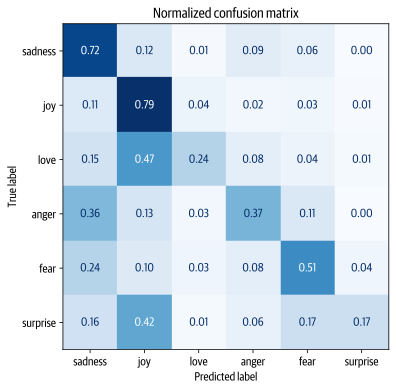

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
    
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

We can see that `anger` and `fear` are most often confused with `sadness`, which agrees with the observation we made when visualizing the embeddings. Also, `love` and `surprise` are frequently mistaken for `joy`.

In the next section we will explore the fine-tuning approach, which leads to superior classification performance. It is, however, important to note that doing this requires more computational resources, such as GPUs, that might not be available in your organization. In cases like these, a feature-based approach can be a good compromise between doing traditional machine learning and deep learning.

### Fine-Tuning Transformers


Let's now explore what it takes to fine-tune a transformer end-to-end. With the fine-tuning approach we do not use the hidden states as fixed features, but instead train them as shown in <<encoder-tuning>>. This requires the classification head to be differentiable, which is why this method usually uses a neural network for classification.

<img alt="encoder-tuning" caption="When using the fine-tuning approach the whole DistilBERT model is trained along with the classification head" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter02_encoder-fine-tuning.png?raw=1" id="encoder-tuning"/>

Training the hidden states that serve as inputs to the classification model will help us avoid the problem of working with data that may not be well suited for the classification task. Instead, the initial hidden states adapt during training to decrease the model loss and thus increase its performance.

We'll be using the `Trainer` API from image:images/logo.png[hf,13,13] Transformers to simplify the training loop. Let's look at the ingredients we need to set one up!

#### Loading a pretrained model

The first thing we need is a pretrained DistilBERT model like the one we used in the feature-based approach. The only slight modification is that we use the `AutoModelForSequenceClassification` model instead of `AutoModel`. The difference is that the `AutoModelForSequenceClassification` model has a classification head on top of the pretrained model outputs, which can be easily trained with the base model. We just need to specify how many labels the model has to predict (six in our case), since this dictates the number of outputs the classification head has:

In [319]:
# hide_output
from transformers import AutoModelForSequenceClassification
import torch 

num_labels = 18
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, problem_type="multi_label_classification", num_labels=num_labels)
         .to(device))

In [320]:
#del device
torch.cuda.empty_cache()

You will see a warning that some parts of the model are randomly initialized. This is normal since the classification head has not yet been trained. The next step is to define the metrics that we'll use to evaluate our model's performance during fine-tuning.

#### Defining the performance metrics


To monitor metrics during training, we need to define a `compute_metrics()` function for the `Trainer`.  This function receives an `EvalPrediction` object (which is a named tuple with `predictions` and `label_ids` attributes) and needs to return a dictionary that maps each metric's name to its value. For our application, we'll compute the $F_1$-score and the accuracy of the model as follows:

In [321]:
def accuracy_thresh(y_pred, y_true, thresh=0.5, sigmoid=True): 
    y_pred = torch.from_numpy(y_pred)
    y_true = torch.from_numpy(y_true)
    if sigmoid: 
      y_pred = y_pred.sigmoid()
    return ((y_pred>thresh)==y_true.bool()).float().mean().item()

In [322]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    return {'accuracy_thresh': accuracy_thresh(predictions, labels)}

In [268]:
from sklearn.metrics import accuracy_score, f1_score

'''
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}
'''

'\ndef compute_metrics(pred):\n    labels = pred.label_ids\n    preds = pred.predictions.argmax(-1)\n    f1 = f1_score(labels, preds, average="weighted")\n    acc = accuracy_score(labels, preds)\n    return {"accuracy": acc, "f1": f1}\n'

With the dataset and metrics ready, we just have two final things to take care of before we define the `Trainer` class:

1. Log in to our account on the Hugging Face Hub. This will allow us to push our fine-tuned model to our account on the Hub and share it with the community.
2. Define all the hyperparameters for the training run.

We'll tackle these steps in the next section.

#### Training the model

If you're running this code in a Jupyter notebook, you can log in to the Hub with the following helper function:

In [244]:
from huggingface_hub import notebook_login

notebook_login()

This will display a widget in which you can enter your username and password, or an access token with write privileges. You can find details on how to create access tokens in the [Hub documentation](https://huggingface.co/docs/hub/security#user-access-tokens). If you're working in the terminal, you can log in by running the following command:

```bash
$ huggingface-cli login
```

To define the training parameters, we use the `TrainingArguments` class. This class stores a lot of information and gives you fine-grained control over the training and evaluation. The most important argument to specify is `output_dir`, which is where all the artifacts from training are stored. Here is an example of `TrainingArguments` in all its glory:

In [323]:
from transformers import Trainer, TrainingArguments

batch_size = 16
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False, 
                                  log_level="error")

Here we also set the batch size, learning rate, and number of epochs, and specify to load the best model at the end of the training run. With this final ingredient, we can instantiate and fine-tune our model with the `Trainer`: 

In [324]:
#How do I efficiently pad the tensors to be of equal dimensions and avoid this issue?
#from rich.traceback import install
#install(show_locals=True)

In [325]:
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'label', 'text', 'token_type_ids'],
        num_rows: 10959
    })
    valid: Dataset({
        features: ['attention_mask', 'input_ids', 'label', 'text', 'token_type_ids'],
        num_rows: 3653
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'label', 'text', 'token_type_ids'],
        num_rows: 3653
    })
})

In [326]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["valid"],
                  tokenizer=tokenizer)
trainer.train();

Epoch,Training Loss,Validation Loss,Accuracy Thresh
1,0.198000,0.124453,0.961326
2,0.105900,0.098738,0.972093


In [ ]:
trainer.evaluate();

In [275]:
import torch
torch.cuda.empty_cache()

Looking at the logs, we can see that our model has an $F_1$-score on the validation set of around 92% - this is a significant improvement over the feature-based approach!

We can take a more detailed look at the training metrics by calculating the confusion matrix. To visualize the confusion matrix, we first need to get the predictions on the validation set. The `predict()` method of the `Trainer` class returns several useful objects we can use for evaluation:

In [330]:
# hide_output
preds_output = trainer.predict(emotions_encoded["valid"])

The output of the `predict()` method is a `PredictionOutput` object that contains arrays of `predictions` and `label_ids`, along with the metrics we passed to the trainer. For example, the metrics on the validation set can be accessed as follows:

In [331]:
preds_output.metrics

{'test_accuracy_thresh': 0.9720929265022278,
 'test_loss': 0.09873761236667633,
 'test_runtime': 70.2984,
 'test_samples_per_second': 51.964,
 'test_steps_per_second': 3.258}

It also contains the raw predictions for each class. We can decode the predictions greedily using `np.argmax()`. This yields the predicted labels and has the same format as the labels returned by the Scikit-Learn models in the feature-based approach:

In [332]:
y_preds = np.argmax(preds_output.predictions, axis=1)

In [336]:
from sklearn.metrics import plot_confusion_matrix

With the predictions, we can plot the confusion matrix again:

In [337]:
plot_confusion_matrix(y_preds, y_valid, labels)

NameError: ignored

#### Error analysis

Before moving on, we should investigate our model's predictions a little bit further. A simple yet powerful technique is to sort the validation samples by the model loss. When we pass the label during the forward pass, the loss is automatically calculated and returned. Here's a function that returns the loss along with the predicted label:

In [328]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device), 
                             reduction="none")

    # Place outputs on CPU for compatibility with other dataset columns   
    return {"loss": loss.cpu().numpy(), 
            "predicted_label": pred_label.cpu().numpy()}

Using the `map()` method once more, we can apply this function to get the losses for all the samples:

In [333]:
#hide_output
# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["valid"].map(
    forward_pass_with_label, batched=True, batch_size=16)

  0%|          | 0/229 [00:00<?, ?ba/s]

Finally, we create a `DataFrame` with the texts, losses, and predicted/true labels:

In [334]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["valid"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

KeyError: ignored

We can now easily sort `emotions_encoded` by the losses in either ascending or descending order. The goal of this exercise is to detect one of the following:

- _Wrong labels_:: Every process that adds labels to data can be flawed. Annotators can make mistakes or disagree, while labels that are inferred from other features can be wrong. If it was easy to automatically annotate data, then we would not need a model to do it. Thus, it is normal that there are some wrongly labeled examples. With this approach, we can quickly find and correct them.

- _Quirks of the dataset_:: Datasets in the real world are always a bit messy. When working with text, special characters or strings in the inputs can have a big impact on the model's predictions. Inspecting the model's weakest predictions can help identify such features, and cleaning the data or injecting similar examples can make the model more robust.

Let's first have a look at the data samples with the highest losses:

In [ ]:
#hide_output
df_test.sort_values("loss", ascending=False).head(10)

We can clearly see that the model predicted some of the labels incorrectly. On the other hand, it seems that there are quite a few examples with no clear class, which might be either mislabeled or require a new class altogether. In particular, `joy` seems to be mislabeled several times. With this information we can refine the dataset, which often can lead to as big a performance gain (or more) as having more data or larger models!

When looking at the samples with the lowest losses, we observe that the model seems to be most confident when predicting the `sadness` class. Deep learning models are exceptionally good at finding and exploiting shortcuts to get to a prediction. For this reason, it is also worth investing time into looking at the examples that the model is most confident about, so that we can be confident that the model does not improperly exploit certain features of the text. So, let's also look at the predictions with the smallest loss:

In [ ]:
#hide_output
df_test.sort_values("loss", ascending=True).head(10)

We now know that the `joy` is sometimes mislabeled and that the model is most confident about predicting the label `sadness`. With this information we can make targeted improvements to our dataset, and also keep an eye on the class the model seems to be very confident about. 

The last step before serving the trained model is to save it for later usage. image:images/logo.png[hf,13,13] Transformers allows us to do this in a few steps, which we'll show you in the next section.

#### Saving and sharing the model


The NLP community benefits greatly from sharing pretrained and fine-tuned models, and everybody can share their models with others via the Hugging Face Hub. Any community-generated model can be downloaded from the Hub just like we downloaded the DistilBERT model. With the `Trainer` API, saving and sharing a model is simple:

In [ ]:
#hide_output
trainer.push_to_hub(commit_message="Training completed!")

We can also use the fine-tuned model to make predictions on new tweets. Since we've pushed our model to the Hub, we can now use it with the `pipeline()` function, just like we did in <<chapter_introduction>>. First, let's load the pipeline:

In [ ]:
#hide_output
from transformers import pipeline

# Change `transformersbook` to your Hub username
model_id = "transformersbook/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

Then let's test the pipeline with a sample tweet:

In [ ]:
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, return_all_scores=True)

Finally, we can plot the probability for each class in a bar plot. Clearly, the model estimates that the most likely class is `joy`, which appears to be reasonable given the tweet:

In [ ]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()